In [137]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf


In [138]:
codes_list = ['ZCN24.CBT','ZCU24.CBT', 'ZCZ24.CBT','ZCH25.CBT','ZCK25.CBT','ZCN25.CBT','ZCU25.CBT','ZCZ25.CBT','ZCH26.CBT','ZCK26.CBT','ZCN26.CBT','ZCU26.CBT','ZCZ26.CBT']
dfs_list = []
for i in codes_list:
#for each code in codes list(all available contracts until end of 2026), I create a ticker element 
#pull the historical dataframe and append to a list
    i_ticker = yf.Ticker(i)

    i_df = i_ticker.history(period = 'max')
    dfs_list.append(i_df)


In [139]:
vix_code = '^VIX'
vix_ticker= yf.Ticker(vix_code)

vix_df = vix_ticker.history(start='2020-12-15')
vix_df.index = vix_df.index.date
print(vix_df)
vix_df['vix'] = vix_df['Close'] 


             Open       High        Low      Close  Volume  Dividends  \
2020-12-15  24.00  24.070000  22.730000  22.889999       0        0.0   
2020-12-16  22.51  23.670000  22.290001  22.500000       0        0.0   
2020-12-17  21.98  22.270000  21.520000  21.930000       0        0.0   
2020-12-18  22.15  23.770000  21.570000  21.570000       0        0.0   
2020-12-21  24.25  31.459999  24.230000  25.160000       0        0.0   
...           ...        ...        ...        ...     ...        ...   
2024-06-10  13.09  13.280000  12.620000  12.740000       0        0.0   
2024-06-11  12.85  13.470000  12.780000  12.850000       0        0.0   
2024-06-12  13.10  13.150000  11.940000  12.040000       0        0.0   
2024-06-13  12.05  12.680000  11.880000  11.940000       0        0.0   
2024-06-14  12.22  13.450000  12.120000  12.660000       0        0.0   

            Stock Splits  
2020-12-15           0.0  
2020-12-16           0.0  
2020-12-17           0.0  
2020-12-18     

In [140]:
# Variables 
for i, df in enumerate(dfs_list):    
    # Daily Returns
    df.index = df.index.date
    df['Returns'] = df['Close'].pct_change() * 100

    df['Month Returns'] = df['Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-30)

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    df = pd.merge(df, vix_df['vix'], left_index=True, right_index=True)
    dfs_list[i] = df  # Assign the modified df back to the list


dfs_dct = dict(zip(codes_list, dfs_list))

In [141]:
#OLS

def ols(merged_df):
    merged_df = merged_df.dropna()

    #Specifying Axes 
    x_vars = ['Returns', 'Momentum RSI', 'Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP','vix']
    X = merged_df.loc[:, x_vars] #Selecting only from merged_df
    y = merged_df['Month Returns']

    #Training Model 

    #Training and Testing Data 
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

    # Fit the OLS model
    X = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    #Model Evaluations 

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
    mse = mean_squared_error(y_test, y_pred)

    # Print model summary and evaluation metrics
    print(model.summary())
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error(MSE): {mse:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.title('Actual vs Predicted')
    plt.show()


              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2020-12-15  395.75  395.75  395.75  395.75       0        0.0           0.0   
2020-12-16  397.25  397.25  397.25  397.25       0        0.0           0.0   
2020-12-17  398.00  398.00  398.00  398.00       0        0.0           0.0   
2020-12-18  398.50  398.50  398.50  398.50       0        0.0           0.0   
2020-12-21  398.50  398.50  398.50  398.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  448.75  452.75  447.75  451.75  230930        0.0           0.0   
2024-06-11  450.75  456.25  449.00  449.50  271960        0.0           0.0   
2024-06-12  449.00  455.00  448.50  454.25  276468        0.0           0.0   
2024-06-13  453.50  460.50  453.50  458.50  296248        0.0           0.0   
2024-06-14  458.00  459.50  448.00  450.00  296248        0.0           0.0   

             Returns  Month Returns  Momentum RSI  

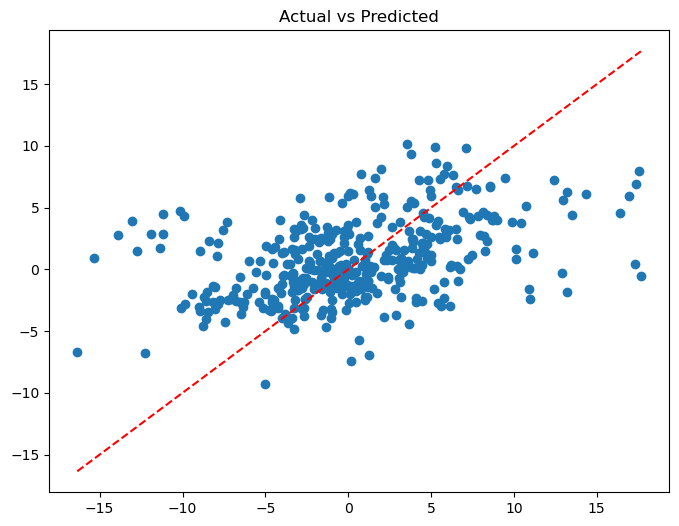



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2021-12-14  510.00  510.00  510.00  510.00       0        0.0           0.0   
2021-12-15  508.75  508.75  508.75  508.75       0        0.0           0.0   
2021-12-16  509.75  509.75  509.75  509.75       0        0.0           0.0   
2021-12-17  509.25  509.25  509.25  509.25       0        0.0           0.0   
2021-12-20  508.25  508.25  508.25  508.25       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  454.75  458.00  454.25  456.25  126902        0.0           0.0   
2024-06-11  455.25  458.75  453.00  453.75  155757        0.0           0.0   
2024-06-12  453.25  457.50  450.75  456.75  144560        0.0           0.0   
2024-06-13  456.50  464.00  456.00  463.50  172683        0.0           0.0   
2024-06-14  463.00  465.25  454.75  457.00  172683        0.0           0.0   

             Returns  Month Returns  Momentum RSI

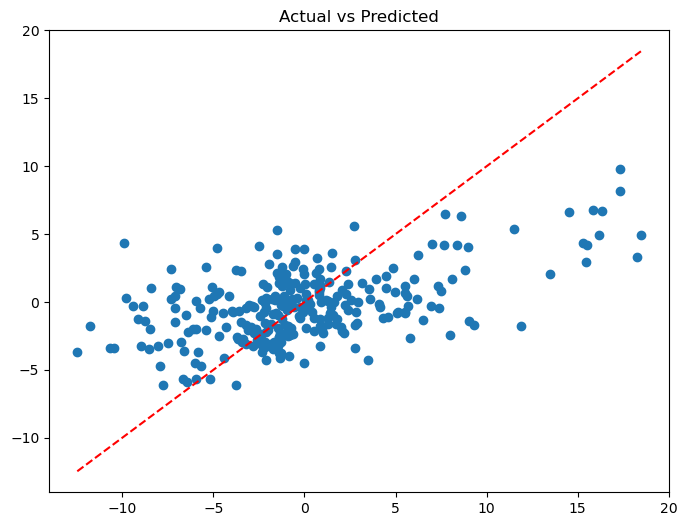



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2020-12-15  395.75  395.75  395.75  395.75       0        0.0           0.0   
2020-12-16  397.25  397.25  397.25  397.25       1        0.0           0.0   
2020-12-17  400.00  400.00  398.00  398.00       1        0.0           0.0   
2020-12-18  398.50  398.50  398.50  398.50       0        0.0           0.0   
2020-12-21  398.50  398.50  398.50  398.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  467.00  470.50  466.75  468.25  106905        0.0           0.0   
2024-06-11  467.50  471.25  464.50  465.25  132845        0.0           0.0   
2024-06-12  464.50  469.25  462.25  468.75  140035        0.0           0.0   
2024-06-13  468.50  476.50  468.25  476.00  163649        0.0           0.0   
2024-06-14  475.50  478.00  468.25  470.25  163649        0.0           0.0   

             Returns  Month Returns  Momentum RSI

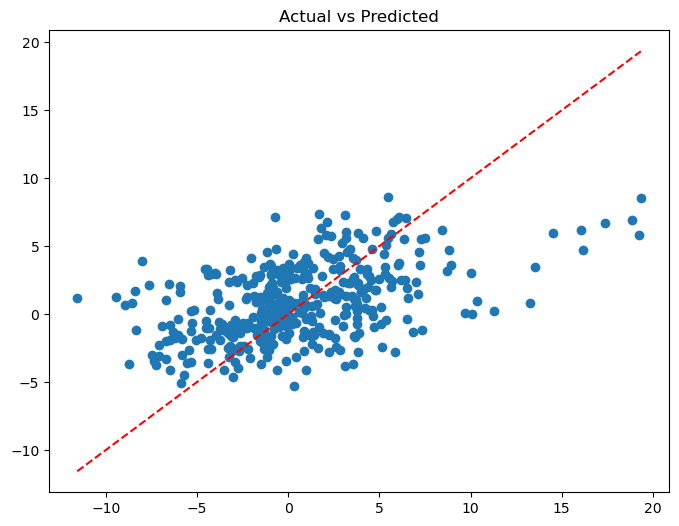



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2022-12-14  567.75  567.75  567.75  567.75       0        0.0           0.0   
2022-12-15  569.25  569.25  569.25  569.25       1        0.0           0.0   
2022-12-16  560.00  567.50  560.00  567.50       1        0.0           0.0   
2022-12-19  567.50  567.50  567.50  567.50       0        0.0           0.0   
2022-12-20  570.00  570.00  565.50  565.50       1        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  479.50  482.50  479.00  480.25   15867        0.0           0.0   
2024-06-11  479.75  483.50  476.50  477.25   15758        0.0           0.0   
2024-06-12  476.50  480.50  474.00  479.75   18936        0.0           0.0   
2024-06-13  479.75  487.00  479.50  486.25   24521        0.0           0.0   
2024-06-14  485.75  488.00  479.00  481.25   24521        0.0           0.0   

             Returns  Month Returns  Momentum RSI

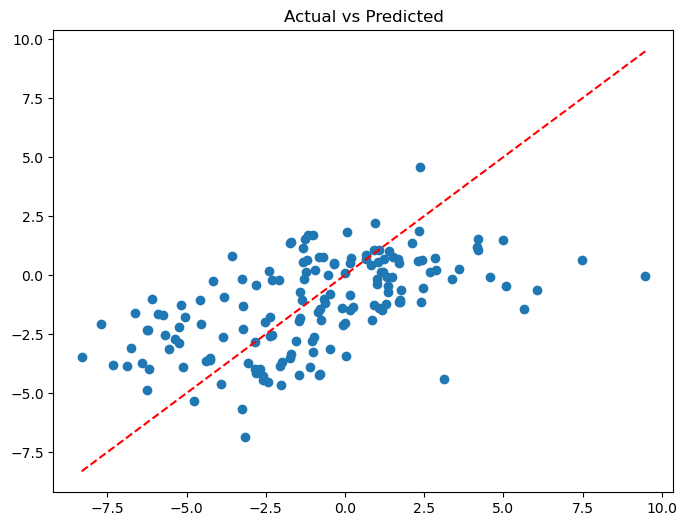



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2022-12-14  570.75  570.75  570.75  570.75       0        0.0           0.0   
2022-12-15  572.25  572.25  572.25  572.25       0        0.0           0.0   
2022-12-16  570.50  570.50  570.50  570.50       0        0.0           0.0   
2022-12-19  570.50  570.50  570.50  570.50       0        0.0           0.0   
2022-12-20  568.50  568.50  568.50  568.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  487.50  490.00  486.50  488.25    7843        0.0           0.0   
2024-06-11  487.50  491.25  484.50  485.00    7428        0.0           0.0   
2024-06-12  484.00  488.00  482.25  487.00    9683        0.0           0.0   
2024-06-13  487.00  494.00  486.75  493.50    6951        0.0           0.0   
2024-06-14  492.75  494.75  486.25  488.25    6951        0.0           0.0   

             Returns  Month Returns  Momentum RSI

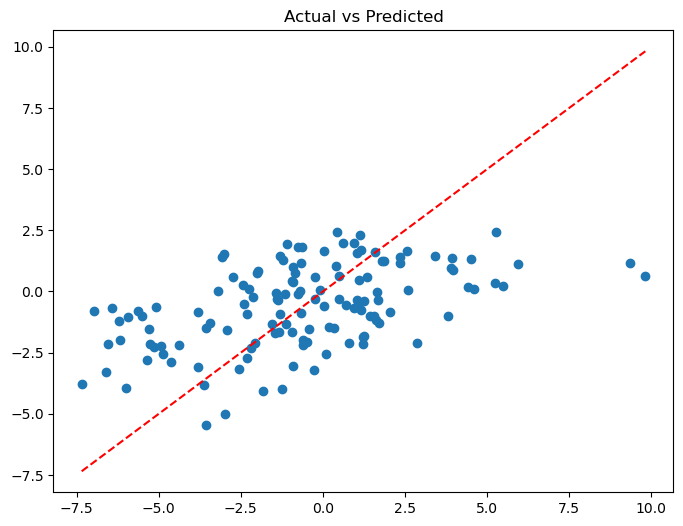



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2021-12-14  477.50  477.50  477.50  477.50       0        0.0           0.0   
2021-12-15  476.25  476.25  476.25  476.25       0        0.0           0.0   
2021-12-16  478.00  478.00  478.00  478.00       0        0.0           0.0   
2021-12-17  477.50  477.50  477.50  477.50       0        0.0           0.0   
2021-12-20  475.00  475.00  475.00  475.00       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  492.50  495.50  492.25  494.50    7864        0.0           0.0   
2024-06-11  494.00  497.50  490.75  491.25    7017        0.0           0.0   
2024-06-12  490.25  494.00  489.00  492.50    7855        0.0           0.0   
2024-06-13  492.25  499.50  492.25  499.25    5460        0.0           0.0   
2024-06-14  498.75  500.00  491.25  493.25    5460        0.0           0.0   

             Returns  Month Returns  Momentum RSI

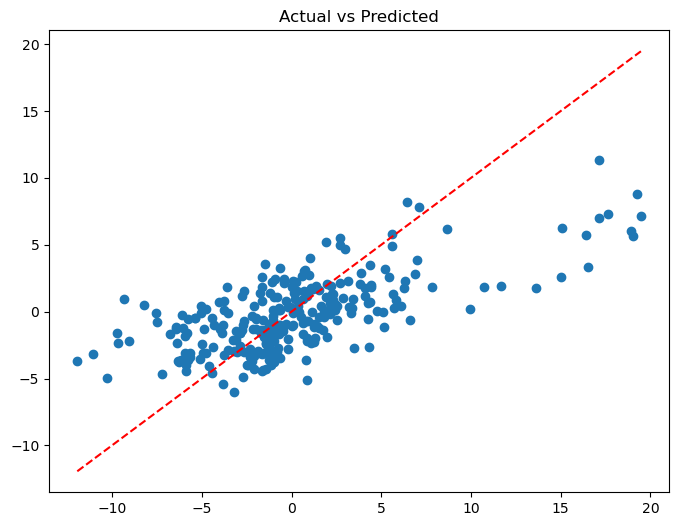



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2022-12-14  530.00  530.00  530.00  530.00       0        0.0           0.0   
2022-12-15  531.75  531.75  531.75  531.75       0        0.0           0.0   
2022-12-16  530.00  530.00  530.00  530.00       0        0.0           0.0   
2022-12-19  530.50  530.50  530.50  530.50       0        0.0           0.0   
2022-12-20  528.50  528.50  528.50  528.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  477.25  479.75  477.00  478.75     734        0.0           0.0   
2024-06-11  478.75  480.50  475.25  476.00     898        0.0           0.0   
2024-06-12  474.50  477.75  473.50  476.75     545        0.0           0.0   
2024-06-13  477.50  482.75  477.50  482.25     759        0.0           0.0   
2024-06-14  481.00  482.25  476.50  477.50     759        0.0           0.0   

             Returns  Month Returns  Momentum RSI

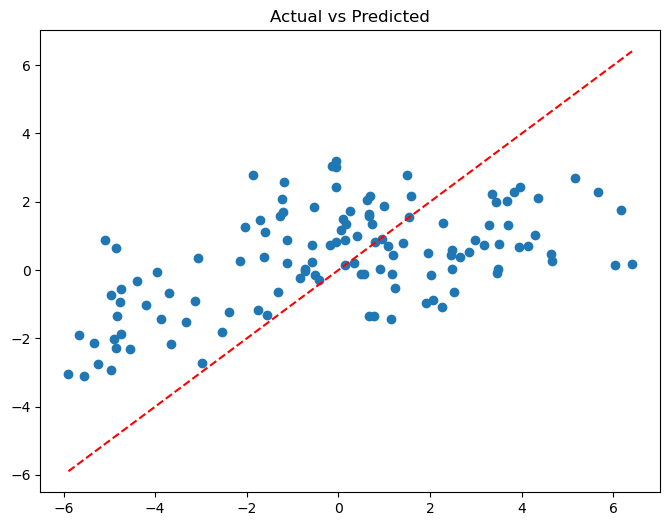



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2021-12-14  477.50  477.50  477.50  477.50       0        0.0           0.0   
2021-12-15  476.25  476.25  476.25  476.25       0        0.0           0.0   
2021-12-16  478.00  478.00  478.00  478.00       0        0.0           0.0   
2021-12-17  477.50  477.50  477.50  477.50       0        0.0           0.0   
2021-12-20  475.00  475.00  475.00  475.00       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  478.25  482.00  478.00  480.00    1961        0.0           0.0   
2024-06-11  478.00  482.00  476.75  477.50    1536        0.0           0.0   
2024-06-12  476.50  479.25  475.25  478.50    1575        0.0           0.0   
2024-06-13  478.25  484.50  478.25  483.25    1713        0.0           0.0   
2024-06-14  482.50  484.50  478.00  478.75    1713        0.0           0.0   

             Returns  Month Returns  Momentum RSI

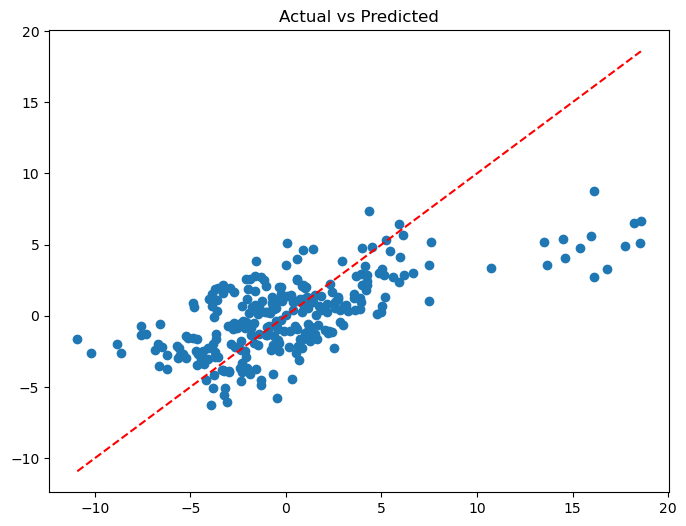



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2023-12-14  517.50  517.50  517.50  517.50       0        0.0           0.0   
2023-12-15  519.00  519.00  519.00  519.00       0        0.0           0.0   
2023-12-18  520.50  520.50  520.50  520.50       0        0.0           0.0   
2023-12-19  514.00  514.00  514.00  514.00       0        0.0           0.0   
2023-12-20  513.75  513.75  513.75  513.75       1        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  491.25  491.25  489.50  489.75      30        0.0           0.0   
2024-06-11  490.75  491.00  487.50  487.50       5        0.0           0.0   
2024-06-12  487.75  488.50  485.25  488.25      13        0.0           0.0   
2024-06-13  490.25  493.25  490.25  492.75      64        0.0           0.0   
2024-06-14  492.50  494.00  488.50  488.50      64        0.0           0.0   

             Returns  Month Returns  Momentum RSI

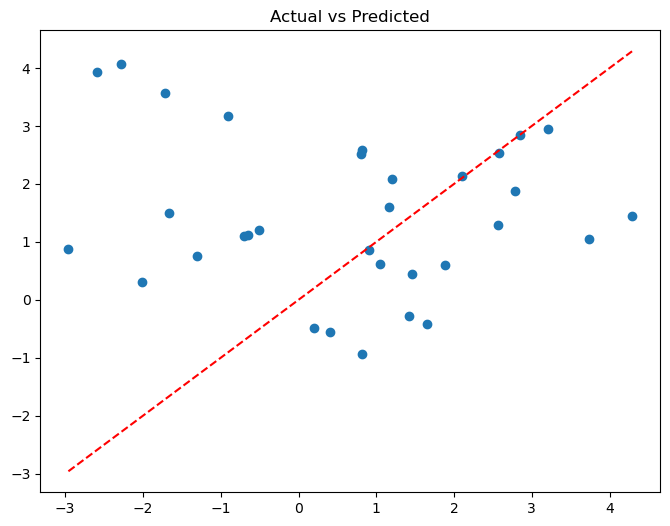



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2023-12-14  522.25  522.25  522.25  522.25       0        0.0           0.0   
2023-12-15  523.75  523.75  523.75  523.75       0        0.0           0.0   
2023-12-18  525.25  525.25  525.25  525.25       0        0.0           0.0   
2023-12-19  518.75  518.75  518.75  518.75       0        0.0           0.0   
2023-12-20  518.50  518.50  518.50  518.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  496.00  496.00  496.00  496.00       5        0.0           0.0   
2024-06-11  493.75  493.75  493.75  493.75       1        0.0           0.0   
2024-06-12  495.00  495.00  494.50  494.50       7        0.0           0.0   
2024-06-13  498.75  498.75  498.75  498.75      26        0.0           0.0   
2024-06-14  498.50  498.50  494.75  494.75      26        0.0           0.0   

             Returns  Month Returns  Momentum RSI

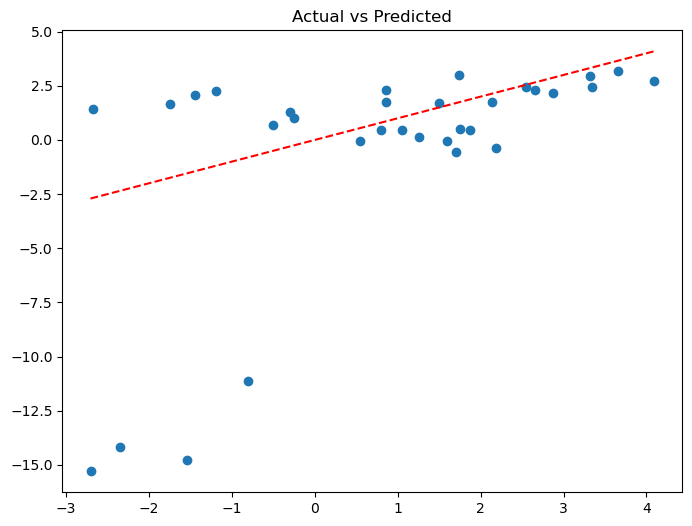



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2022-12-14  527.75  527.75  527.75  527.75       0        0.0           0.0   
2022-12-15  528.25  528.25  528.25  528.25       0        0.0           0.0   
2022-12-16  527.75  527.75  527.75  527.75       0        0.0           0.0   
2022-12-19  527.25  527.25  527.25  527.25       0        0.0           0.0   
2022-12-20  525.50  525.50  525.50  525.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  501.75  501.75  500.50  500.50       9        0.0           0.0   
2024-06-11  500.50  500.50  498.25  498.25       2        0.0           0.0   
2024-06-12  499.25  499.50  498.50  499.00      12        0.0           0.0   
2024-06-13  500.00  503.25  500.00  503.25       3        0.0           0.0   
2024-06-14  502.75  503.00  499.25  499.25       3        0.0           0.0   

             Returns  Month Returns  Momentum RSI

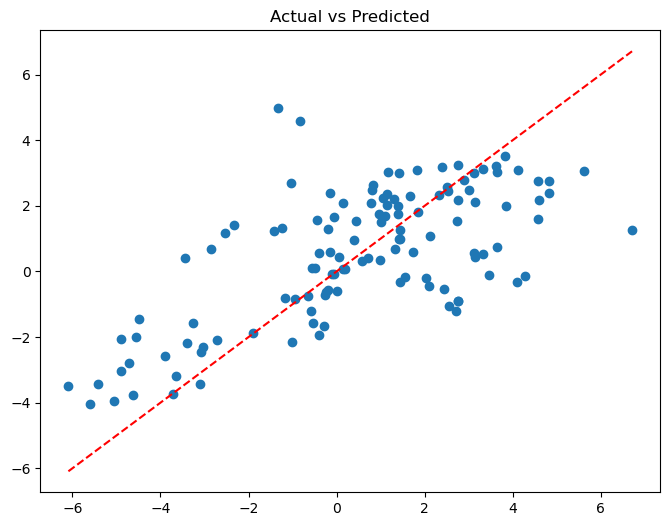



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2023-12-14  508.25  508.25  508.25  508.25       0        0.0           0.0   
2023-12-15  509.75  509.75  509.75  509.75       0        0.0           0.0   
2023-12-18  511.25  511.25  511.25  511.25       0        0.0           0.0   
2023-12-19  504.75  504.75  504.75  504.75       0        0.0           0.0   
2023-12-20  504.50  504.50  504.50  504.50       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  472.25  472.25  472.25  472.25       0        0.0           0.0   
2024-06-11  469.75  469.75  469.75  469.75       0        0.0           0.0   
2024-06-12  471.75  471.75  471.75  471.75       0        0.0           0.0   
2024-06-13  475.75  475.75  475.75  475.75       0        0.0           0.0   
2024-06-14  472.50  472.50  472.50  472.50       0        0.0           0.0   

             Returns  Month Returns  Momentum RSI

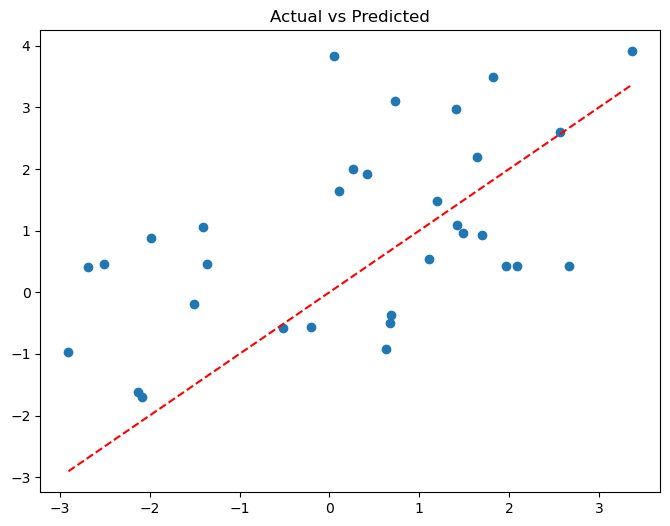



              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2022-12-14  484.25  484.25  484.25  484.25       0        0.0           0.0   
2022-12-15  484.75  484.75  484.75  484.75       0        0.0           0.0   
2022-12-16  485.25  485.25  485.25  485.25       0        0.0           0.0   
2022-12-19  485.00  485.00  485.00  485.00       0        0.0           0.0   
2022-12-20  485.25  485.25  485.25  485.25       0        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-10  472.00  472.50  470.25  471.00       8        0.0           0.0   
2024-06-11  471.75  472.00  468.50  468.50      32        0.0           0.0   
2024-06-12  468.00  470.75  467.75  470.75      46        0.0           0.0   
2024-06-13  472.00  475.00  472.00  474.75      33        0.0           0.0   
2024-06-14  476.00  476.00  471.25  471.25      33        0.0           0.0   

             Returns  Month Returns  Momentum RSI

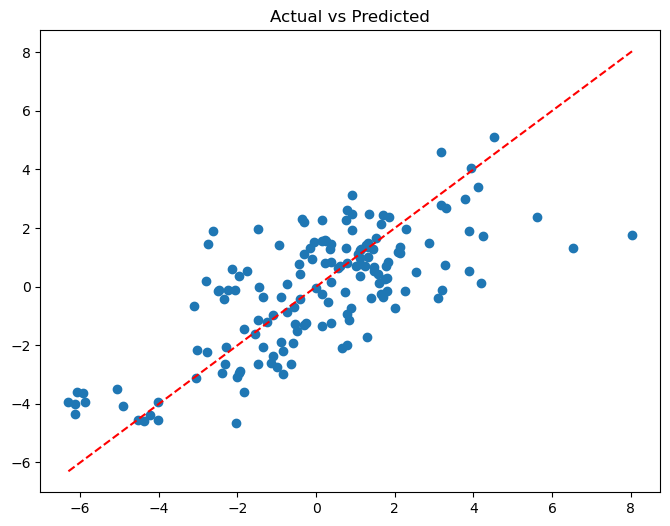

In [142]:
#Inputs for OLS 
for name, df in dfs_dct.items():
    print(df)
    print(f'OLS Summary {name}:')
    ols(df)
    print('\n')

In [143]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [144]:
# Visualization: Actual vs Predicted
'''
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')\nplt.xlabel('Actual')\nplt.ylabel('Predicted')\nplt.title('Actual vs Predicted')\nplt.show()\n"

In [145]:
'''
# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")
'''

'\n# Set up Optuna study\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=50)\n\n# Get the best hyperparameters\nbest_params = study.best_params\n\n# Train the model with the best hyperparameters\nrf_best = RandomForestRegressor(**best_params, random_state=42)\nrf_best.fit(X_train, y_train)\n\n# Evaluate the model\ny_pred = rf_best.predict(X_test)\nmae = mean_absolute_error(y_test, y_pred)\nrmse = root_mean_squared_error(y_test, y_pred)\nmse = mean_squared_error(y_test, y_pred)\n\nprint(f"Best Hyperparameters: {best_params}")\nprint(f"Mean Absolute Error (MAE): {mae:.2f}")\nprint(f"Root Mean Squared Error (RMSE): {rmse:.2f}")\nprint(f"Mean Squared Error(MSE): {mse:.2f}")\n'

In [146]:
'''
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

'\n# Visualization: Feature Importance\nfeature_importances = rf_best.feature_importances_\nsorted_indices = np.argsort(feature_importances)[::-1]\nplt.figure(figsize=(10, 6))\nplt.title("Feature Importances")\nplt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")\nplt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)\nplt.tight_layout()\nplt.show()\n\n# Visualization: Actual vs Predicted\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], \'--\', color=\'red\')\nplt.xlabel(\'Actual\')\nplt.ylabel(\'Predicted\')\nplt.title(\'Actual vs Predicted\')\nplt.show()\n'